In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# -----------------------------
# 0. Random Seed
# -----------------------------
import random
import numpy as np
import tensorflow as tf

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

!pip install xgboost

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# -----------------------------
# 1. Load Data & Scaler
# -----------------------------
import pandas as pd
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

base_path = "/content/drive/MyDrive/Estimate_Final_Project"

train_df = pd.read_csv(f"{base_path}/train_us101.csv")
val_df   = pd.read_csv(f"{base_path}/val_us101.csv")
test_df  = pd.read_csv(f"{base_path}/test_us101.csv")

with open(f"{base_path}/scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

feature_cols = ["Local_X", "Local_Y", "v_Vel", "v_Acc", "speed_calc", "accel_calc"]
target_cols  = ["Local_X", "Local_Y"]


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:

# -----------------------------
# 2. GPU Check
# -----------------------------
if tf.config.list_physical_devices('GPU'):
    device = '/GPU:0'
    print("Using GPU")
else:
    device = '/CPU:0'
    print("Using CPU")


Using GPU


In [ ]:
# -----------------------------
# 3. Sequence Maker
# -----------------------------
def make_sequences(df, feature_cols, target_cols, seq_len):
    X_list, y_list = [], []
    values = df[feature_cols + target_cols].values

    for i in range(len(values) - seq_len):
        seq_x = values[i:i+seq_len, :len(feature_cols)]
        seq_y = values[i+seq_len, len(feature_cols):]
        X_list.append(seq_x)
        y_list.append(seq_y)

    return np.array(X_list), np.array(y_list)

In [ ]:
# -----------------------------
# 4. Build LSTM Model (Improved Version)
# -----------------------------
def build_lstm(input_dim, seq_len, units=64):

    model = Sequential([

        # First LSTM layer (returns full sequences)
        LSTM(units, return_sequences=True, input_shape=(seq_len, input_dim)),

        # Second LSTM layer
        LSTM(units // 2),

        # Enhanced Dense layers
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(2)
    ])

    model.compile(optimizer='adam', loss='mse')
    return model


In [ ]:
# -----------------------------
# 5. Train with multiple seq_len
# -----------------------------
seq_lens = [5,8,10]
results = {}

for seq_len in seq_lens:
    print(f"\n====== Training LSTM with seq_len={seq_len} ======\n")

    X_train, y_train = make_sequences(train_df, feature_cols, target_cols, seq_len)
    X_val,   y_val   = make_sequences(val_df, feature_cols, target_cols, seq_len)

    with tf.device(device):
        model = build_lstm(len(feature_cols), seq_len)

        best_val = float("inf")
        patience = 30
        wait = 0
        EPOCHS = 1000

        for epoch in range(1, EPOCHS + 1):
            history = model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=1,
                batch_size=64,
                verbose=0
            )

            train_loss = history.history['loss'][0]
            val_loss   = history.history['val_loss'][0]

            if epoch % 5 == 0:
                print(f"[Epoch {epoch}/{EPOCHS}] train={train_loss:.6f}, val={val_loss:.6f}")

            if val_loss < best_val:
                best_val = val_loss
                wait = 0
                print(f"Best update (seq_len={seq_len}) at epoch {epoch}: {best_val:.6f}")
            else:
                wait += 1
                if wait >= patience:
                    print(f"EarlyStopping at epoch {epoch} (seq_len={seq_len})")
                    break

    results[seq_len] = best_val

print("\nValidation Results:", results)


====== Training LSTM with seq_len=5 ======



/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best update (seq_len=5) at epoch 1: 0.011185
Best update (seq_len=5) at epoch 2: 0.007212
Best update (seq_len=5) at epoch 3: 0.006777
Best update (seq_len=5) at epoch 4: 0.006595
[Epoch 5/1000] train=0.007059, val=0.006399
Best update (seq_len=5) at epoch 5: 0.006399
Best update (seq_len=5) at epoch 6: 0.006239
Best update (seq_len=5) at epoch 8: 0.006172
Best update (seq_len=5) at epoch 9: 0.006139
[Epoch 10/1000] train=0.006536, val=0.006232
[Epoch 15/1000] train=0.006251, val=0.006427
Best update (seq_len=5) at epoch 16: 0.006032
Best update (seq_len=5) at epoch 18: 0.005331
Best update (seq_len=5) at epoch 19: 0.005311
[Epoch 20/1000] train=0.005783, val=0.005387
Best update (seq_len=5) at epoch 22: 0.005275
[Epoch 25/1000] train=0.006051, val=0.005513
Best update (seq_len=5) at epoch 27: 0.005182
Best update (seq_len=5) at epoch 29: 0.005156
[Epoch 30/1000] train=0.005543, val=0.005115
Best update (seq_len=5) at epoch 30: 0.005115
[Epoch 35/1000] train=0.005377, val=0.004857
Best

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best update (seq_len=8) at epoch 1: 0.009083
Best update (seq_len=8) at epoch 2: 0.007582
Best update (seq_len=8) at epoch 3: 0.006995
[Epoch 5/1000] train=0.007150, val=0.006934
Best update (seq_len=8) at epoch 5: 0.006934
Best update (seq_len=8) at epoch 6: 0.006496
Best update (seq_len=8) at epoch 7: 0.006380
Best update (seq_len=8) at epoch 8: 0.006256
[Epoch 10/1000] train=0.006606, val=0.006147
Best update (seq_len=8) at epoch 10: 0.006147
Best update (seq_len=8) at epoch 11: 0.006096
Best update (seq_len=8) at epoch 12: 0.005924
Best update (seq_len=8) at epoch 13: 0.005909
Best update (seq_len=8) at epoch 14: 0.005862
[Epoch 15/1000] train=0.006273, val=0.005775
Best update (seq_len=8) at epoch 15: 0.005775
Best update (seq_len=8) at epoch 16: 0.005678
Best update (seq_len=8) at epoch 18: 0.005609
Best update (seq_len=8) at epoch 19: 0.005508
[Epoch 20/1000] train=0.005808, val=0.005711
Best update (seq_len=8) at epoch 21: 0.005418
Best update (seq_len=8) at epoch 24: 0.005406


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best update (seq_len=10) at epoch 1: 0.009553
Best update (seq_len=10) at epoch 2: 0.007120
Best update (seq_len=10) at epoch 3: 0.006969
Best update (seq_len=10) at epoch 4: 0.006334
[Epoch 5/1000] train=0.007251, val=0.006627
Best update (seq_len=10) at epoch 7: 0.006087
[Epoch 10/1000] train=0.006833, val=0.006171
Best update (seq_len=10) at epoch 12: 0.005687
Best update (seq_len=10) at epoch 13: 0.005593
Best update (seq_len=10) at epoch 14: 0.005286
[Epoch 15/1000] train=0.006342, val=0.005181
Best update (seq_len=10) at epoch 15: 0.005181
Best update (seq_len=10) at epoch 17: 0.005003
[Epoch 20/1000] train=0.005999, val=0.004776
Best update (seq_len=10) at epoch 20: 0.004776
Best update (seq_len=10) at epoch 21: 0.004737
Best update (seq_len=10) at epoch 22: 0.004672
Best update (seq_len=10) at epoch 23: 0.004589
Best update (seq_len=10) at epoch 24: 0.004479
[Epoch 25/1000] train=0.005999, val=0.004523
Best update (seq_len=10) at epoch 27: 0.004372
Best update (seq_len=10) at e

In [ ]:
# -------------------------------------------------------
# 6. Best seq_len
# -------------------------------------------------------
best_seq = min(results, key=results.get)
print(f"\nBest seq_len = {best_seq} (val_loss={results[best_seq]:.6f})")



Best seq_len = 10 (val_loss=0.003510)


In [ ]:
# -----------------------------
# 7. Final Training
# -----------------------------
seq_len = best_seq
X_train, y_train = make_sequences(train_df, feature_cols, target_cols, seq_len)
X_val,   y_val   = make_sequences(val_df, feature_cols, target_cols, seq_len)
X_test,  y_test  = make_sequences(test_df, feature_cols, target_cols, seq_len)

with tf.device(device):
    final_model = build_lstm(len(feature_cols), seq_len)

    best_val = float("inf")
    patience = 30
    wait = 0
    EPOCHS = 1000

    for epoch in range(1, EPOCHS + 1):
        history = final_model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=1,
            batch_size=64,
            verbose=0
        )

        train_loss = history.history['loss'][0]
        val_loss = history.history['val_loss'][0]

        if epoch % 5 == 0:
            print(f"[Final Epoch {epoch}/{EPOCHS}] train={train_loss:.6f}, val={val_loss:.6f}")

        if val_loss < best_val:
            best_val = val_loss
            wait = 0
            print(f"Final Best Update at epoch {epoch}: {best_val:.6f}")
        else:
            wait += 1
            if wait >= patience:
                print(f"Final EarlyStopping at epoch {epoch}")
                break


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Final Best Update at epoch 1: 0.008680
Final Best Update at epoch 2: 0.007036
Final Best Update at epoch 3: 0.006794
Final Best Update at epoch 4: 0.006595
[Final Epoch 5/1000] train=0.007065, val=0.006380
Final Best Update at epoch 5: 0.006380
Final Best Update at epoch 6: 0.006333
Final Best Update at epoch 7: 0.005997
Final Best Update at epoch 8: 0.005989
Final Best Update at epoch 9: 0.005615
[Final Epoch 10/1000] train=0.006608, val=0.005583
Final Best Update at epoch 10: 0.005583
Final Best Update at epoch 11: 0.005443
Final Best Update at epoch 12: 0.005359
Final Best Update at epoch 13: 0.005240
Final Best Update at epoch 14: 0.005157
[Final Epoch 15/1000] train=0.006218, val=0.005095
Final Best Update at epoch 15: 0.005095
Final Best Update at epoch 16: 0.004999
Final Best Update at epoch 18: 0.004903
Final Best Update at epoch 19: 0.004841
[Final Epoch 20/1000] train=0.005937, val=0.004766
Final Best Update at epoch 20: 0.004766
Final Best Update at epoch 21: 0.004681
Final 

In [ ]:
# -----------------------------
# 8. Test Evaluation
# -----------------------------
test_loss = final_model.evaluate(X_test, y_test)
print(f"\nFinal Test Loss = {test_loss:.6f}")

# Predictions
test_pred = final_model.predict(X_test)
test_last_feat = X_test[:, -1, :]


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0048

Final Test Loss = 0.004912
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
# -----------------------------
# 9. XGBoost Training
# -----------------------------
from xgboost import XGBRegressor

train_pred = final_model.predict(X_train)
val_pred   = final_model.predict(X_val)

train_res = y_train - train_pred
val_res   = y_val   - val_pred
test_res  = y_test  - test_pred

train_last_feat = X_train[:, -1, :]
val_last_feat   = X_val[:, -1, :]

train_xgb_input = np.concatenate([train_last_feat, train_pred], axis=1)
val_xgb_input   = np.concatenate([val_last_feat,   val_pred],  axis=1)
test_xgb_input  = np.concatenate([test_last_feat,  test_pred], axis=1)

train_xgb_target = train_res
val_xgb_target   = val_res

xgb_x = XGBRegressor(
    n_estimators=300, learning_rate=0.05, max_depth=5,
    subsample=0.8, colsample_bytree=0.8
)

xgb_y = XGBRegressor(
    n_estimators=300, learning_rate=0.05, max_depth=5,
    subsample=0.8, colsample_bytree=0.8
)

print("Training XGBoost models...")

xgb_x.fit(train_xgb_input, train_xgb_target[:, 0],
          eval_set=[(val_xgb_input, val_xgb_target[:, 0])],
          verbose=False)

xgb_y.fit(train_xgb_input, train_xgb_target[:, 1],
          eval_set=[(val_xgb_input, val_xgb_target[:, 1])],
          verbose=False)

print("XGBoost Residual Models Trained")

733/733 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training XGBoost models...
XGBoost Residual Models Trained


In [ ]:
# -----------------------------
# 10. Apply Y-only Correction
# -----------------------------
res_x = xgb_x.predict(test_xgb_input)
res_y = xgb_y.predict(test_xgb_input)

final_pred_scaled = np.zeros_like(test_pred)
final_pred_scaled[:, 0] = test_pred[:, 0]          # X unchanged
final_pred_scaled[:, 1] = test_pred[:, 1] + res_y  # Y corrected

final_scaled_full = np.concatenate([test_last_feat, final_pred_scaled], axis=1)
final_pred_real = scaler.inverse_transform(final_scaled_full)[:, -2:]

true_scaled_full = np.concatenate([test_last_feat, y_test], axis=1)
true_real = scaler.inverse_transform(true_scaled_full)[:, -2:]



In [ ]:
# -----------------------------
# 11. MSE Calculation
# -----------------------------
from sklearn.metrics import mean_squared_error

lstm_full_all = np.concatenate([test_last_feat, test_pred], axis=1)
lstm_pred_real_all = scaler.inverse_transform(lstm_full_all)[:, -2:]

mse_lstm_x = mean_squared_error(true_real[:,0], lstm_pred_real_all[:,0])
mse_lstm_y = mean_squared_error(true_real[:,1], lstm_pred_real_all[:,1])
mse_lstm_total = mean_squared_error(true_real, lstm_pred_real_all)

mse_corr_x = mean_squared_error(true_real[:,0], final_pred_real[:,0])
mse_corr_y = mean_squared_error(true_real[:,1], final_pred_real[:,1])
mse_corr_total = mean_squared_error(true_real, final_pred_real)

print("\n==============================")
print("MSE Comparison (Test Set)")
print("==============================")

print(f"LSTM MSE (X): {mse_lstm_x:.6f}")
print(f"LSTM MSE (Y): {mse_lstm_y:.6f}")
print(f"LSTM MSE (Total 2D): {mse_lstm_total:.6f}")

print(f"\nCorrected MSE (X): {mse_corr_x:.6f}   (X uses LSTM only)")
print(f"Corrected MSE (Y): {mse_corr_y:.6f}")
print(f"Corrected MSE (Total 2D): {mse_corr_total:.6f}")

print("\nImprovement:")
print("X: 0%   (unchanged)")
print(f"Y: {(mse_lstm_y - mse_corr_y) / mse_lstm_y * 100:.2f}%")
print(f"Total: {(mse_lstm_total - mse_corr_total) / mse_lstm_total * 100:.2f}%")


MSE Comparison (Test Set)
LSTM MSE (X): 0.491678
LSTM MSE (Y): 3004.093151
LSTM MSE (Total 2D): 1502.292414

Corrected MSE (X): 0.491678   (X uses LSTM only)
Corrected MSE (Y): 1953.511029
Corrected MSE (Total 2D): 977.001353

Improvement:
X: 0%   (unchanged)
Y: 34.97%
Total: 34.97%


In [ ]:
rmse_2d_lstm = np.sqrt(mse_lstm_total)
rmse_2d_corr = np.sqrt(mse_corr_total)

print("LSTM 2D RMSE:", rmse_2d_lstm)
print("Corrected 2D RMSE:", rmse_2d_corr)


LSTM 2D RMSE: 38.75941710303807
Corrected 2D RMSE: 31.257020862606613


In [ ]:
# -----------------------------------------
# 1. LSTM 전체 예측 만들어서 inverse transform
# -----------------------------------------
# final_model, X_test, y_test, scaler, feature_cols 존재한다고 가정

# LSTM scaled prediction (전체)
test_pred_scaled = final_model.predict(X_test)

# 마지막 feature (전체)
test_last_features = X_test[:, -1, :]   # shape (N,6)

# Combine feature + predicted (전체 N,8)
test_scaled_full = np.concatenate([test_last_features, test_pred_scaled], axis=1)

# inverse → real 단위 예측
lstm_pred_real_full = scaler.inverse_transform(test_scaled_full)[:, -2:]

# true real 단위
true_scaled_full = np.concatenate([test_last_features, y_test], axis=1)
true_real_full = scaler.inverse_transform(true_scaled_full)[:, -2:]


159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
# Corrected prediction (Y Only)
final_scaled_full = np.concatenate([test_last_features, final_pred_scaled], axis=1)
final_pred_real = scaler.inverse_transform(final_scaled_full)[:, -2:]


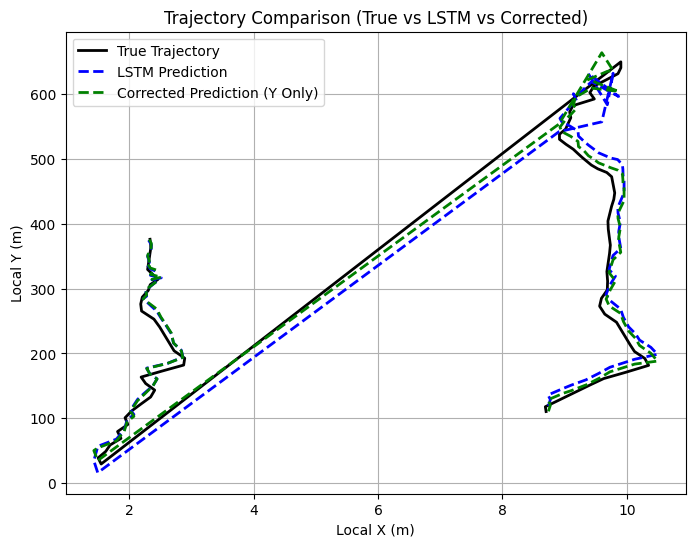

In [ ]:
# ---------------------------------------------------------
# 1. Trajectory Plot (Predicted vs True)
# ---------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np

sample_index = 0
vis_len = 100

sample_true = true_real_full[sample_index:sample_index + vis_len]
sample_lstm = lstm_pred_real_full[sample_index:sample_index + vis_len]
sample_corr = final_pred_real[sample_index:sample_index + vis_len]

plt.figure(figsize=(8, 6))
plt.plot(sample_true[:, 0], sample_true[:, 1], label="True Trajectory", linewidth=2, color='black')
plt.plot(sample_lstm[:, 0], sample_lstm[:, 1], label="LSTM Prediction", linewidth=2, linestyle='--', color='blue')
plt.plot(sample_corr[:, 0], sample_corr[:, 1], label="Corrected Prediction (Y Only)", linewidth=2, linestyle='--', color='green')

plt.xlabel("Local X (m)")
plt.ylabel("Local Y (m)")
plt.title("Trajectory Comparison (True vs LSTM vs Corrected)")
plt.legend()
plt.grid(True)
plt.show()




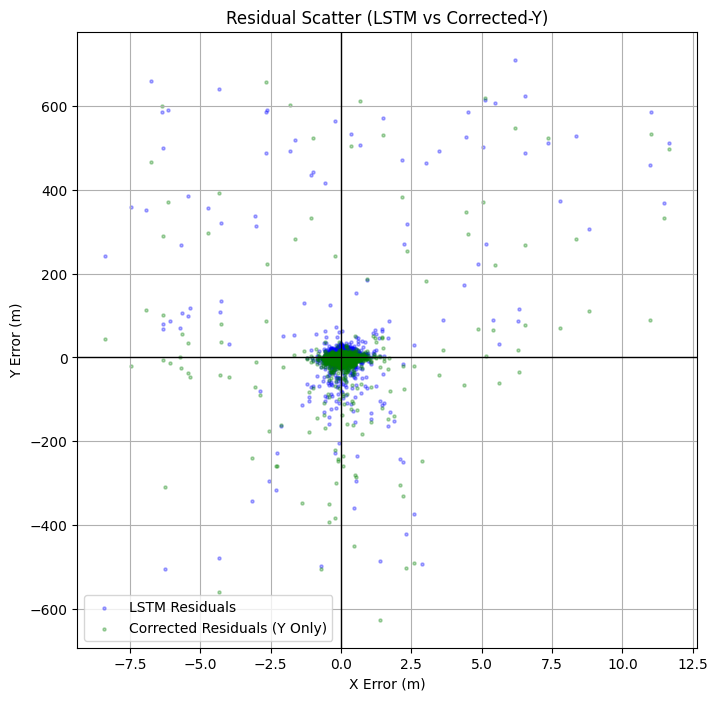

In [ ]:
# ---------------------------------------------------------
# 2. Residual Scatter Plot (LSTM vs Corrected)
# ---------------------------------------------------------

lstm_residuals = lstm_pred_real_full - true_real_full
corr_residuals = final_pred_real - true_real_full

lstm_x_err = lstm_residuals[:, 0]
lstm_y_err = lstm_residuals[:, 1]
corr_x_err = corr_residuals[:, 0]   # corrected X residual == LSTM X residual
corr_y_err = corr_residuals[:, 1]

plt.figure(figsize=(8, 8))
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)

plt.scatter(lstm_x_err, lstm_y_err, alpha=0.3, s=5, label="LSTM Residuals", color='blue')
plt.scatter(corr_x_err, corr_y_err, alpha=0.3, s=5, label="Corrected Residuals (Y Only)", color='green')

plt.xlabel("X Error (m)")
plt.ylabel("Y Error (m)")
plt.title("Residual Scatter (LSTM vs Corrected-Y)")
plt.legend()
plt.grid(True)
plt.show()



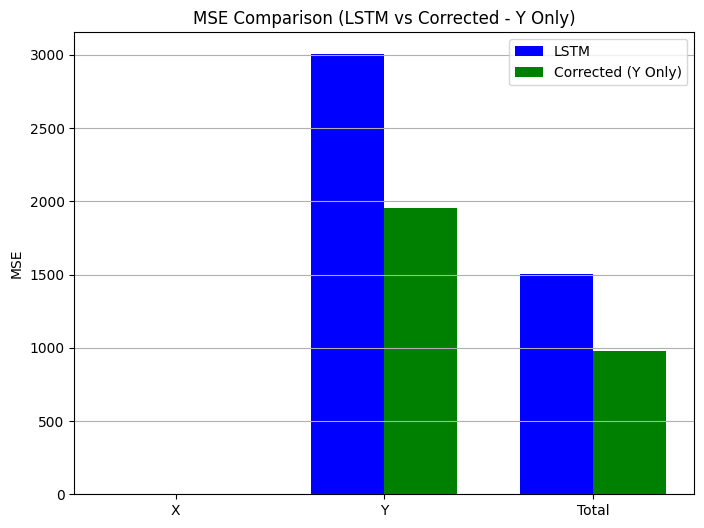

In [ ]:
# ---------------------------------------------------------
# 3. MSE Bar Chart (LSTM vs Corrected / Y Only)
# ---------------------------------------------------------
from sklearn.metrics import mean_squared_error

mse_lstm_x = mean_squared_error(true_real_full[:, 0], lstm_pred_real_full[:, 0])
mse_lstm_y = mean_squared_error(true_real_full[:, 1], lstm_pred_real_full[:, 1])
mse_lstm_total = mean_squared_error(true_real_full, lstm_pred_real_full)

# corrected X should be identical to LSTM X
mse_corr_x = mse_lstm_x
mse_corr_y = mean_squared_error(true_real_full[:, 1], final_pred_real[:, 1])
mse_corr_total = mean_squared_error(true_real_full, final_pred_real)

labels = ["Y", "Total"]
lstm_values = [mse_lstm_x, mse_lstm_y, mse_lstm_total]
corr_values = [mse_corr_x, mse_corr_y, mse_corr_total]  # X unchanged

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8, 6))
plt.bar(x - width/2, lstm_values, width, label="LSTM", color='blue')
plt.bar(x + width/2, corr_values, width, label="Corrected (Y Only)", color='green')

plt.ylabel("MSE")
plt.title("MSE Comparison (LSTM vs Corrected - Y Only)")
plt.xticks(x, labels)
plt.legend()
plt.grid(axis='y')
plt.show()